[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intel-analytics/BigDL/blob/main/python/chronos/colab-notebook/howto/how_to_use_forecaster_to_predict_future_data.ipynb)


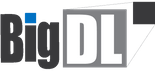

# Predict future data

## Introduction

Once we have trained a forecaster and validate its performance and accuracy, it's time to predict future data. In this guidance, **we demonstrate how to use forecaster to predict future data with and without ground true** in detail.

We will take `TCNForecaster` and nyc_taxi dataset as an example in this guide.

## Setup

To begin our guide, you should prepare your environment and your dataset as introduced in former guides.

In [ ]:
!pip install --pre --upgrade bigdl-chronos[pytorch]
!pip uninstall -y torchtext # uninstall torchtext to avoid version conflict

In [ ]:
from bigdl.chronos.data.repo_dataset import get_public_dataset
from sklearn.preprocessing import StandardScaler
from bigdl.chronos.forecaster.tcn_forecaster import TCNForecaster
from bigdl.chronos.forecaster.autoformer_forecaster import AutoformerForecaster

scaler = StandardScaler()

## Prediction

There are two application scenarios for the prediction function: **prediction with ground truth to validate** and **pure prediction** (without ground truth). 

For different kinds of prediction, the process you prepare your dataset as well as train your forecaster differ. We will introduce the examples for different scenarios seperately.

### 1. Prediction with ground truth

The prediction with ground truth is a continuation of [this guide](https://bigdl.readthedocs.io/en/latest/doc/Chronos/Howto/how_to_train_forecaster_on_one_node.html). We will focus on how to use `forecaster.predict` with `TCNForecaster`.

In [ ]:
# for test

# The get_public_dataset function will return three tsdataset instances with default set: with_split=True, val_ratio=0.1, test_ratio=0.1
tsdata_train, _, tsdata_test = get_public_dataset(name='nyc_taxi')

test_lookback, test_horiozn = 48, 1

# scaled the dataset here
for tsdata in [tsdata_train, tsdata_test]:
    tsdata.deduplicate()\
          .impute()\
          .gen_dt_feature()\
          .scale(scaler, fit=(tsdata is tsdata_train))\
          .roll(lookback=test_lookback, horizon=test_horiozn)

# Create a forecaster by Forecaster.from_tsdataset(Recommended if valid)
test_forecaster = TCNForecaster.from_tsdataset(tsdata_train)

test_forecaster.fit(data=tsdata_train)

`forecaster.predict` supports predicting future data using many formats of history data, you can check the details of different forecasters in the [Forecaster API Doc](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/forecasters.html).

For the `TCNForecaster.predict`, the supported formats including:

1. `bigdl.chronos.data.TSDataset` (**recommended**)
2. numpy ndarray
3. pytorch dataloader
4. xshard item

It's always recommended to use `TSDataset` direcetly when possible. 

You can also try other formats by uncomment different lines to change the `test_data` variable into different type.

In [ ]:
# comment this line if you want to try other formats
test_data = tsdata_test # tsdata_test is a TSDataset variable

# uncomment this line to change `test_data` as numpy ndarray
# test_data, _ = tsdata_test.to_numpy()

# uncomment this line to change `test_data` as pytorch dataloader
# test_data = tsdata_test.to_torch_data_loader(lookback=test_lookback, horizon=test_horiozn)

# Use the fitted forecaster to predict test data
test = test_forecaster.predict(data=test_data)

Congrats! So far you have already finished your first try of `forecaster.predict` successfully. But there is **one more thing** you need to do. 

We should know that we scaled our datasets both for trainning and for predicting by using `tsdataset.scale` when we prepared the dataset before. So the result of prediction here (denoted by `test`) is also scaled. To get the result in original scale, we have to use `tsdataset.unscale_numpy` to unscale the result. 

The input of `tsdataset.unscale_numpy` is a numpy ndarray, which is actually the return value of `forecaster.predict` function. So what we need to do is just passing the result into the `tsdataset.unscale_numpy` function to get the unscaled result.

In [ ]:
# Unscale the predict value to get the result in correct scale
pred_unscale = tsdata_test.unscale_numpy(data=test)

Here we finished our guide of prediction with ground truth.

### 2. Prediction without ground truth (pure prediction)

To make a pure prediction, we can only use `AutoformerForecaster` in current version. And we have to set the following arguments of `tsdataset.roll` like this:

>time_enc=True, label_len="your label len", is_predict=True (when the dataset will be used for prediction, i.e. the `pred_tsdata_test` in example.)

The process of creating a `AutoformerForecaster` as well as preparing the dataset is as follows:

In [ ]:
# for pure prediction

pred_lookback, pred_horizon = 50, 1
label_len = 25

pred_forecaster = AutoformerForecaster(past_seq_len=pred_lookback,
                                       future_seq_len=pred_horizon,
                                       input_feature_num=8,           # The input_feature_num increased to 8 because we will use .gen_dt_feature() function to generate more time features
                                       output_feature_num=1,
                                       label_len=label_len,
                                       freq='t',
                                       seed=2)

pred_tsdata_train, _, pred_tsdata_test = get_public_dataset(name='nyc_taxi')

for tsdata in [pred_tsdata_train, pred_tsdata_test]:
    tsdata.deduplicate()\
          .impute()\
          .gen_dt_feature()\
          .scale(scaler, fit=(tsdata is pred_tsdata_train))\
          .roll(lookback=pred_lookback, horizon=pred_horizon, time_enc=True, label_len=label_len, is_predict=(tsdata is pred_tsdata_test))

predict_train = pred_tsdata_train.to_numpy()
pred_forecaster.fit(predict_train)

For the `AutoformerForecaster.predict`, the supported formats including:

1. numpy ndarrays
2. pytorch dataloader: generate from `TSDataset.to_torch_data_loader`, **be sure to set label_len > 0, time_enc = True and is_predict = True**

You can try pytorch dataloader format by uncomment the lines below.

In [ ]:
# comment this line if you want to try another format
predict_test = pred_tsdata_test.to_numpy()

# uncomment this line to change `predict_test` as pytorch dataloader
# predict_test = pred_tsdata_test.to_torch_data_loader(lookback=pred_lookback, horizon=pred_horizon, time_enc=True, label_len=label_len, is_predict=True)

# Use fitted forecaster to predict test data
pred = pred_forecaster.predict(data=predict_test)

For the last step, we need to pass the result into the `tsdataset.unscale_numpy` function to get the unscaled result.

The return value of `AutoformerForecaster.predict` is a list of numpy ndarray, so we need to unscale it one by one.

In [ ]:
# Unscale the predict value to get the result in correct scale
unscaled_pred = []
for result in pred:
    unscaled_pred.append(pred_tsdata_test.unscale_numpy(result))